In this notebook we summarize performance of using max balanced OT distances between events as an anomaly score.

We consider the following settings:

- 3D ground space
- 2D ground space
<!-- - 2D planed $p_{\rm T}$ ground space -->

In [1]:
NEVENTS = 1000
NREPEAT = 5
NSIGFIGS = 4
EVENT_TO_ENSEMBLE_TYPE = 'MIN' # 'MAX', 'MEAN'
AXIS = 0

# Preliminaries

## Information about data

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for testing out new methods!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [2]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

## Google Drive preliminaries (since we're running on Google Colab)

In [3]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [4]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

anomalyAugmented_background_for_training_50k.h5
anomalyAugmented_background_for_training.h5
Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
finalScoreDict_2D_nEvents1000_nRepeat5_eventToEnsembleTypeMEAN.npz
finalScoreDict_2D_nEvents1000_nRepeat5.npz
finalScoreDict_2D_nEvents10_nRepeat5_eventToEnsembleTypeMAX.npz
finalScoreDict_3DanomalykNN_nEvents1000_nRepeat5.npz
finalScoreDict_3D_nEvents1000_nRepeat5_eventToEnsembleTypeMAX.npz
finalScoreDict_3D_nEvents1000_nRepeat5_eventToEnsembleTypeMEAN.npz
finalScoreDict_3D_nEvents1000_nRepeat5_eventToEnsembleTypeMIN.npz
finalScoreDict_3D_nEvents1000_nRepeat5.npz
finalScoreDict_3D_nEvents10_nRepeat5_eventToEnsembleTypeMAX.npz
finalScoreDict_3DoneClassSVM_nEvents1000_nRepeat5.npz
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets
sampledData_nEvents1000.npz
sampledData_nEvents100.npz
sampledData_nEvents10.npz
train_matrix_10k.npy

In [5]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

## Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)). But since this notebook is just visualizing the data we won't use it yet.

In [6]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

import os.path

## Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [7]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 822.7/822.7 kB 8.4 MB/s eta 0:00:00


## Load data

For more details on the data structure, see [this exploratory notebook](https://colab.research.google.com/drive/138CL8n4gCtramqaaI-i0EUZ7n4f1SWVh?usp=sharing).

In [8]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

# 3D ground space

We'll be using the 2-Wasserstein distance squared as our anomaly score. We assume the ground space is 3 dimensional $(p_T/{\rm GeV}, \eta, \phi)$, where $p_T$ is measured in ${\rm GeV}$.

## Setup details

       OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
                  Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
                  It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
                  whether the OT calculation is balanced, and whether the zero padding should be
                  removed. Namely,
                  OTSCHEME['normPT']      ==True:  Means that the pT should be normalized;
                                         ==False:  Means that the pT should be unnormalized
                  OTSCHEME['balanced']    ==True:  Means that the OT calculation should be balanced;
                                         ==False:  Means that the OT calculation should be unbalanced
                  OTSCHEME['noZeroPad']   ==True:  Means that the zero padding should be removed;
                                         ==False:  Means that the zero padding should be kept
                  OTSCHEME['individualOT']==True:  Means that the OT calculation is done on each species separately;
                                         ==False:  Means that the OT calculation is done ignoring species type    
     COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
                  - 1DpT: Ground space is pT only
                  - 2D:   Ground space is 2D (eta,phi); note mass is pT
                  - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform

In [9]:
OTSCHEME = {}
OTSCHEME['normPT']       = False # pT should be unnormalized per event
OTSCHEME['balanced']     = True  # OT calculation is balanced
OTSCHEME['noZeroPad']    = False # zero padding is kept
OTSCHEME['individualOT'] = False # Don't calculate individual species OT
COSTSCHEME            = '3D'  # pT, eta, phi ground space
kwargs                = {}    # No other arguments to pass to function

In [10]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [11]:
nEvents   = NEVENTS

In [12]:
#-- Check if file with datasamples already exists, if not sample and make one --#
sampledDataFile = basePath + dataPath + 'sampledData_nEvents%s.npz'%(str(nEvents))

if os.path.exists(sampledDataFile):
  dummyDict = np.load(sampledDataFile, allow_pickle=True)

  # Unpack contents
  scoreDict = {}
  for key in dummyDict.files:
    scoreDict[key] = dummyDict[key].item()

else:
  # Dictionary structure to keep results (accounting for repeats to get statistical uncertainty)
  scoreDict = {}
  for irepeat in range(NREPEAT):
    name_repeat = 'repeat%d'%irepeat
    scoreDict[name_repeat] = {}

  # Generate 2 different samples of nEvents Background events
  random_state            = Generator(PCG64(123))
  for irepeat in tqdm(range(NREPEAT)):
    name_repeat = 'repeat%d'%irepeat
    scoreDict[name_repeat]['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

  random_state            = Generator(PCG64(456))
  for irepeat in tqdm(range(NREPEAT)):
    name_repeat = 'repeat%d'%irepeat
    scoreDict[name_repeat]['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

  # For each signal type, generate a sample of nEvents Signal events
  for alias in sigAliasList:
    random_state          = Generator(PCG64(123))
    for irepeat in tqdm(range(NREPEAT)):
      name_repeat = 'repeat%d'%irepeat
      scoreDict[name_repeat][alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

  # Save so we don't have to do this repeatedly...
  np.savez(sampledDataFile, **scoreDict)

## Calculate OT distances

In [13]:
for irepeat in range(NREPEAT):
  name_repeat = 'repeat%d'%irepeat

  #-- For background-to-background case --#
  # Note the 2-Wasserstein distance squared nEvents x nEvents matrix is returned i.e. wXY[i,j] = (W2(X[i], Y[j]))**2
  # We first turn this into an event-to-ensemble distance. Assuming that X comprise the ensemble population => AXIS=0
  # After this we take the square-root. The end result is an array with shape (nEvents,)
  wBB = calcOTDistance_non_square(scoreDict[name_repeat]['bkgEvents1'], scoreDict[name_repeat]['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs, Matrix=True)
  scoreDict[name_repeat]['wBB'] = np.sqrt(event_to_ensemble_dist(wBB, EVENT_TO_ENSEMBLE_TYPE=EVENT_TO_ENSEMBLE_TYPE, AXIS=AXIS))

  #-- For background-to-signal case --#
  for alias in sigAliasList:
    name_w = 'wBS_'+alias

    wBS = calcOTDistance_non_square(scoreDict[name_repeat]['bkgEvents1'], scoreDict[name_repeat][alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs, Matrix=True)
    scoreDict[name_repeat][name_w] = np.sqrt(event_to_ensemble_dist(wBS, EVENT_TO_ENSEMBLE_TYPE=EVENT_TO_ENSEMBLE_TYPE, AXIS=AXIS))

100%|██████████| 1000000/1000000 [07:40<00:00, 2173.54it/s]


In [14]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)
print('scoreDict[repeati] keys:')
for subkey in scoreDict['repeat0']:
  print("  ",subkey)

scoreDict keys:
   repeat0
   repeat1
   repeat2
   repeat3
   repeat4
scoreDict[repeati] keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   wBB
   wBS_sig_A
   wBS_sig_h0
   wBS_sig_hch
   wBS_sig_LQ


## Get ROC metrics for all repeats

In [15]:
for irepeat in range(NREPEAT):
  name_repeat = 'repeat%d'%irepeat

  #-- Put in convenient list format --#
  scoreBkg = scoreDict[name_repeat]['wBB']
  scoreSigList = []
  for alias in sigAliasList:
    name = 'wBS_'+alias
    scoreSigList.append(scoreDict[name_repeat][name])

  aucList, fprList, tprList, SIList, fprInvList, F1List = calcROCmetrics(scoreBkg, scoreSigList, INTERPOLATE=True)

  #-- Store everything in a dictionary --#
  for i, alias in enumerate(sigAliasList):
    name = 'ROC_metric_'+alias
    scoreDict[name_repeat][name]           = {}
    scoreDict[name_repeat][name]['auc']    = aucList[i]
    scoreDict[name_repeat][name]['fpr']    = fprList[i]
    scoreDict[name_repeat][name]['tpr']    = tprList[i]
    scoreDict[name_repeat][name]['SI']     = SIList[i]
    scoreDict[name_repeat][name]['fprInv'] = fprInvList[i]
    scoreDict[name_repeat][name]['F1']     = F1List[i]

## Get and report average performance for tables

In [16]:
#-- Get average and std of performance metrics --#
print(scoreDict.keys())
getRepeatAvStd(scoreDict)
print(scoreDict.keys())
print(scoreDict['avStdQuantities']['sig_A'].keys())

dict_keys(['repeat0', 'repeat1', 'repeat2', 'repeat3', 'repeat4'])
Analyzing signal type = sig_A 
Analyzing signal type = sig_h0 
Analyzing signal type = sig_hch 
Analyzing signal type = sig_LQ 
dict_keys(['repeat0', 'repeat1', 'repeat2', 'repeat3', 'repeat4', 'avStdQuantities'])
dict_keys(['auc', 'fpr', 'SI', 'fprInv', 'F1'])


In [17]:
#-- Report results for tables--#
indx = indxOfCertainTPR([np.linspace(0, 1, 101)], TPRval = 0.3)[0] # Assuming base TPR value

print("AUC:")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['auc']['mean'], scoreDict['avStdQuantities'][alias]['auc']['std'])

print("Inverse FPR at TPR=0.3")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['fprInv']['mean'][indx], scoreDict['avStdQuantities'][alias]['fprInv']['std'][indx])

print("SI at TPR=0.3")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['SI']['mean'][indx], scoreDict['avStdQuantities'][alias]['SI']['std'][indx])

print("F1 at TPR=0.3")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['F1']['mean'][indx], scoreDict['avStdQuantities'][alias]['F1']['std'][indx])

AUC:
   sig_A, mean, std:  0.8370246 0.008751988062149087
   sig_h0, mean, std:  0.7417808000000001 0.008213406781597972
   sig_hch, mean, std:  0.9129014000000002 0.005798000296654011
   sig_LQ, mean, std:  0.8410019999999999 0.007098310700441376
Inverse FPR at TPR=0.3
   sig_A, mean, std:  17.683279206244556 3.1399621451286945
   sig_h0, mean, std:  17.81052281052281 3.977066905611035
   sig_hch, mean, std:  63.402132782937734 11.013148049479678
   sig_LQ, mean, std:  18.58742670685018 3.1280388918691444
SI at TPR=0.3
   sig_A, mean, std:  1.2554004484448718 0.11210379972968604
   sig_h0, mean, std:  1.2576388396227072 0.13527824201046712
   sig_hch, mean, std:  2.372680339382117 0.1988954173916546
   sig_LQ, mean, std:  1.287528419051837 0.10930570718989831
F1 at TPR=0.3
   sig_A, mean, std:  0.44172246304750595 0.0034091323281791245
   sig_h0, mean, std:  0.4416606946439674 0.0036259563424679993
   sig_hch, mean, std:  0.4558593952244568 0.0008606176703733557
   sig_LQ, mean, std: 

In [18]:
# Same order as above but easier for copying over to draft
print("AUC:")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['auc']['mean'], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['auc']['std'], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

print("Inverse FPR at TPR=0.3")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['fprInv']['mean'][indx], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['fprInv']['std'][indx], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

print("SI at TPR=0.3")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['SI']['mean'][indx], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['SI']['std'][indx], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

print("F1 at TPR=0.3")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['F1']['mean'][indx], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['F1']['std'][indx], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

AUC:
0.837  $\pm$  0.008752
0.7418  $\pm$  0.008213
0.9129  $\pm$  0.005798
0.841  $\pm$  0.007098
Inverse FPR at TPR=0.3
17.68  $\pm$  3.14
17.81  $\pm$  3.977
63.4  $\pm$  11.01
18.59  $\pm$  3.128
SI at TPR=0.3
1.255  $\pm$  0.1121
1.258  $\pm$  0.1353
2.373  $\pm$  0.1989
1.288  $\pm$  0.1093
F1 at TPR=0.3
0.4417  $\pm$  0.003409
0.4417  $\pm$  0.003626
0.4559  $\pm$  0.0008606
0.4427  $\pm$  0.003124


## Make plots

In [19]:
av_fprList, std_fprList = [], []
for alias in sigAliasList:
  av_fprList.append(scoreDict['avStdQuantities'][alias]['fpr']['mean'])
  std_fprList.append(scoreDict['avStdQuantities'][alias]['fpr']['std'])

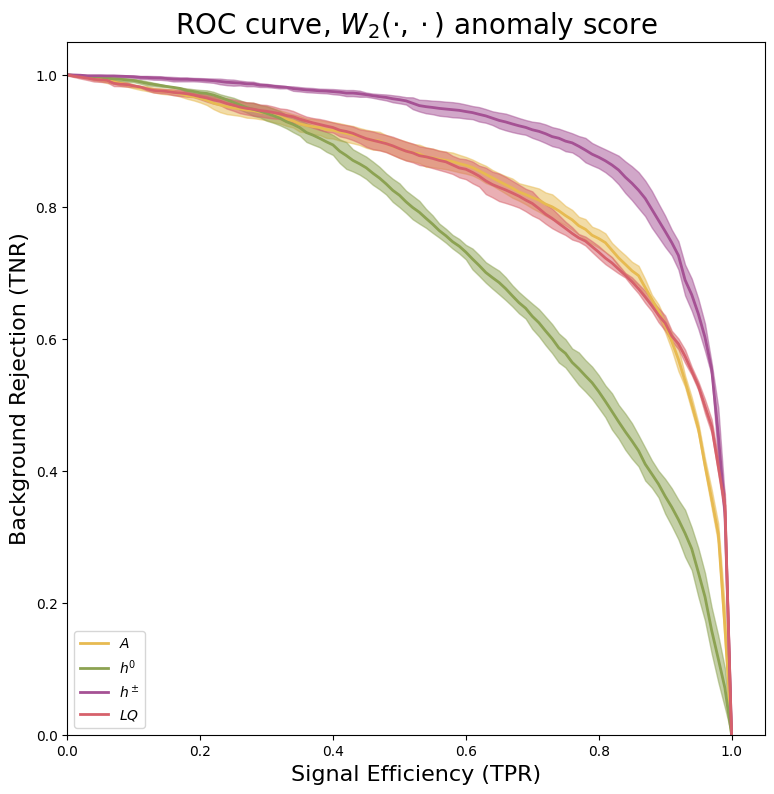

In [20]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)' # OR r'$\eps_S$'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)' # OR r'$1 - \eps_B$'
plotArgDict['title']     = r'ROC curve, $W_2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve_errorBand(av_fprList, std_fprList, plotArgDict)

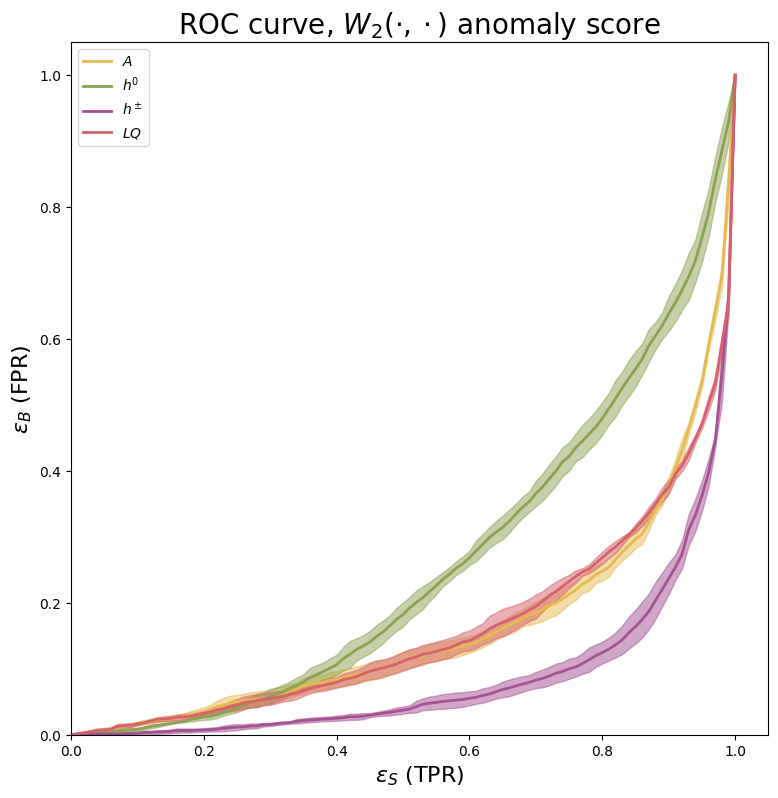

In [21]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve_errorBand(av_fprList, std_fprList, plotArgDict, TYPE='Alt')

In [22]:
av_fprInvList, std_fprInvList = [], []
for alias in sigAliasList:
  av_fprInvList.append(scoreDict['avStdQuantities'][alias]['fprInv']['mean'])
  std_fprInvList.append(scoreDict['avStdQuantities'][alias]['fprInv']['std'])

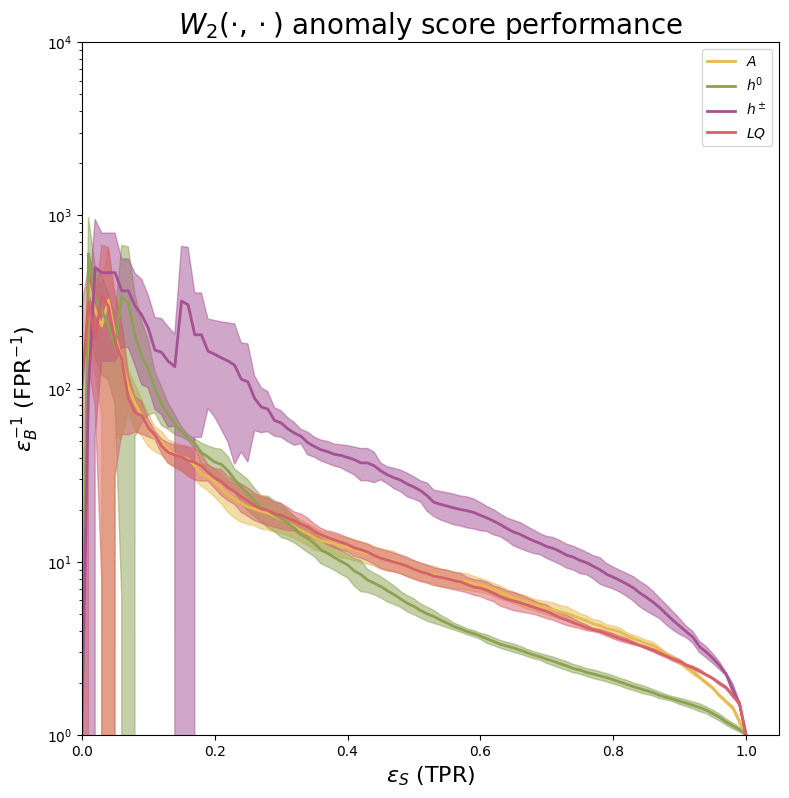

In [23]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve_errorBand(av_fprInvList, std_fprInvList, plotArgDict)

In [24]:
av_SIList, std_SIList = [], []
for alias in sigAliasList:
  av_SIList.append(scoreDict['avStdQuantities'][alias]['SI']['mean'])
  std_SIList.append(scoreDict['avStdQuantities'][alias]['SI']['std'])

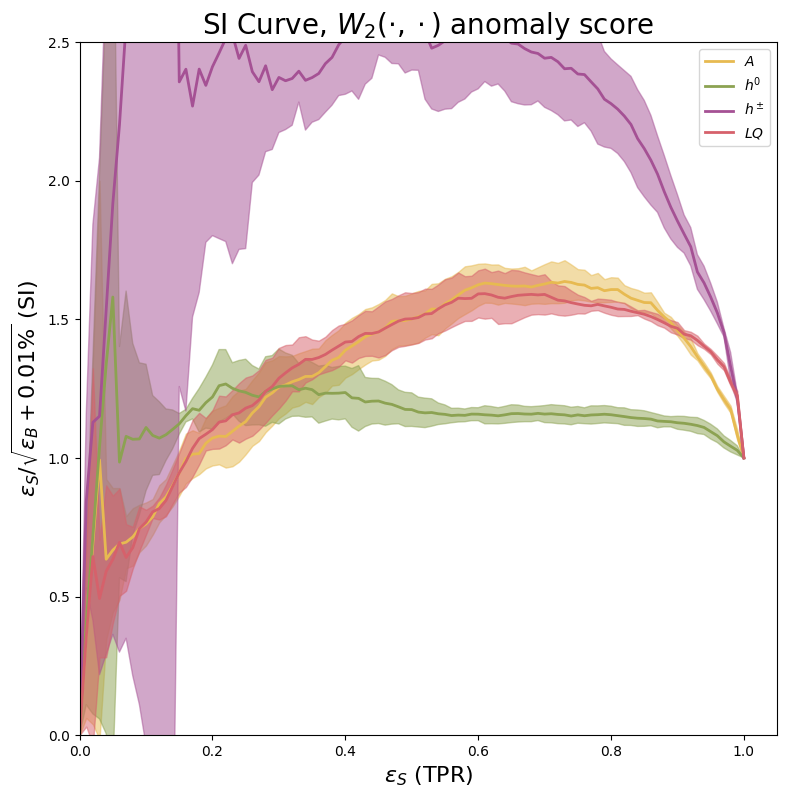

In [25]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 2.5)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve_errorBand(av_SIList, std_SIList, plotArgDict)

## Plot anomaly scores for all signal types

In [26]:
print(scoreDict.keys())
NAME_REPEAT = list(scoreDict.keys())[0]

dict_keys(['repeat0', 'repeat1', 'repeat2', 'repeat3', 'repeat4', 'avStdQuantities'])


In [27]:
#-- Put in convenient list format --#
scoreBkg = scoreDict[NAME_REPEAT]['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[NAME_REPEAT][name])

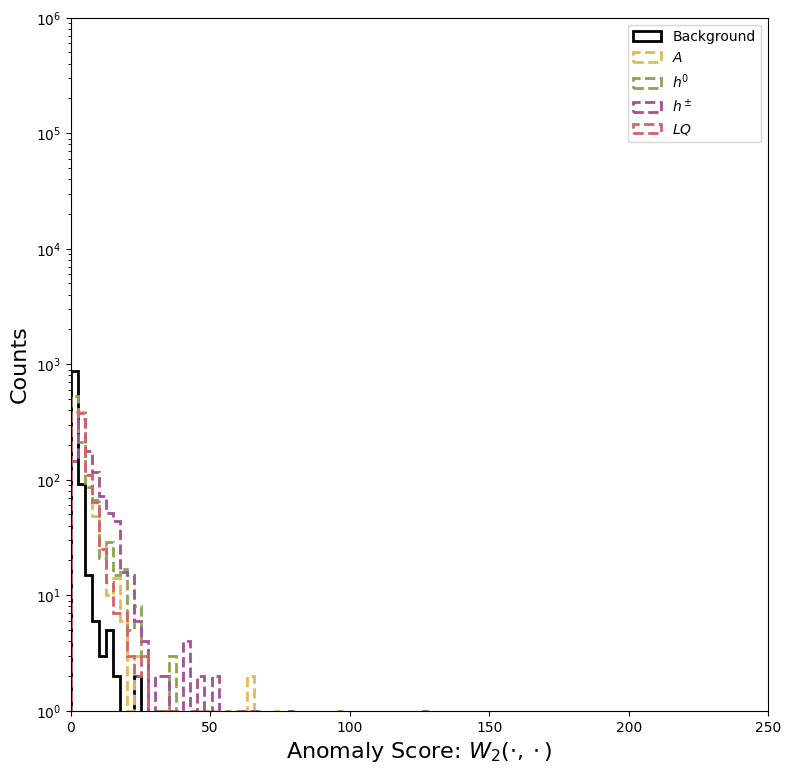

In [28]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 250)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e6)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Save final scoreDict

In [29]:
filename = basePath + dataPath + 'finalScoreDict_%s_nEvents%s_nRepeat%s_eventToEnsembleType%s.npz'%(COSTSCHEME, str(nEvents), str(NREPEAT), EVENT_TO_ENSEMBLE_TYPE)
print(filename)

if os.path.exists(filename):
  print("File already exists")
else:
  np.savez(filename, **scoreDict)

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/finalScoreDict_3D_nEvents1000_nRepeat5_eventToEnsembleTypeMIN.npz


# 2D ground space

We'll be using the 2-Wasserstein distance squared as our anomaly score. We assume the ground space is 2 dimensional $(\eta, \phi)$, with normalized $p_T /\sum p_T$ as the probability mass.

## Setup details

       OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
                  Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
                  It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
                  whether the OT calculation is balanced, and whether the zero padding should be
                  removed. Namely,
                  OTSCHEME['normPT']      ==True:  Means that the pT should be normalized;
                                         ==False:  Means that the pT should be unnormalized
                  OTSCHEME['balanced']    ==True:  Means that the OT calculation should be balanced;
                                         ==False:  Means that the OT calculation should be unbalanced
                  OTSCHEME['noZeroPad']   ==True:  Means that the zero padding should be removed;
                                         ==False:  Means that the zero padding should be kept
                  OTSCHEME['individualOT']==True:  Means that the OT calculation is done on each species separately;
                                         ==False:  Means that the OT calculation is done ignoring species type    
     COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
                  - 1DpT: Ground space is pT only
                  - 2D:   Ground space is 2D (eta,phi); note mass is pT
                  - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform

In [9]:
OTSCHEME = {}
OTSCHEME['normPT']       = True  # pT should be normalized per event
OTSCHEME['balanced']     = True  # OT calculation is balanced
OTSCHEME['noZeroPad']    = False # zero padding is kept
OTSCHEME['individualOT'] = False # Don't calculate individual species OT
COSTSCHEME            = '2D'  # pT, eta, phi ground space
kwargs                = {}    # No other arguments to pass to function

In [10]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [11]:
nEvents   = NEVENTS

In [12]:
#-- Check if file with datasamples already exists, if not sample and make one --#
sampledDataFile = basePath + dataPath + 'sampledData_nEvents%s.npz'%(str(nEvents))

if os.path.exists(sampledDataFile):
  dummyDict = np.load(sampledDataFile, allow_pickle=True)

  # Unpack contents
  scoreDict = {}
  for key in dummyDict.files:
    scoreDict[key] = dummyDict[key].item()

else:
  # Dictionary structure to keep results (accounting for repeats to get statistical uncertainty)
  scoreDict = {}
  for irepeat in range(NREPEAT):
    name_repeat = 'repeat%d'%irepeat
    scoreDict[name_repeat] = {}

  # Generate 2 different samples of nEvents Background events
  random_state            = Generator(PCG64(123))
  for irepeat in tqdm(range(NREPEAT)):
    name_repeat = 'repeat%d'%irepeat
    scoreDict[name_repeat]['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

  random_state            = Generator(PCG64(456))
  for irepeat in tqdm(range(NREPEAT)):
    name_repeat = 'repeat%d'%irepeat
    scoreDict[name_repeat]['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

  # For each signal type, generate a sample of nEvents Signal events
  for alias in sigAliasList:
    random_state          = Generator(PCG64(123))
    for irepeat in tqdm(range(NREPEAT)):
      name_repeat = 'repeat%d'%irepeat
      scoreDict[name_repeat][alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

  # Save so we don't have to do this repeatedly...
  np.savez(sampledDataFile, **scoreDict)

## Calculate OT distances

In [13]:
for irepeat in range(NREPEAT):
  name_repeat = 'repeat%d'%irepeat

  #-- For background-to-background case --#
  # Note the 2-Wasserstein distance squared nEvents x nEvents matrix is returned i.e. wXY[i,j] = (W2(X[i], Y[j]))**2
  # We first turn this into an event-to-ensemble distance. Assuming that X comprise the ensemble population => AXIS=0
  # After this we take the square-root. The end result is an array with shape (nEvents,)
  wBB = calcOTDistance_non_square(scoreDict[name_repeat]['bkgEvents1'], scoreDict[name_repeat]['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs, Matrix=True)
  scoreDict[name_repeat]['wBB'] = np.sqrt(event_to_ensemble_dist(wBB, EVENT_TO_ENSEMBLE_TYPE=EVENT_TO_ENSEMBLE_TYPE, AXIS=AXIS))

  #-- For background-to-signal case --#
  for alias in sigAliasList:
    name_w = 'wBS_'+alias

    wBS = calcOTDistance_non_square(scoreDict[name_repeat]['bkgEvents1'], scoreDict[name_repeat][alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs, Matrix=True)
    scoreDict[name_repeat][name_w] = np.sqrt(event_to_ensemble_dist(wBS, EVENT_TO_ENSEMBLE_TYPE=EVENT_TO_ENSEMBLE_TYPE, AXIS=AXIS))

100%|██████████| 1000000/1000000 [10:32<00:00, 1579.98it/s]


In [14]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)
print('scoreDict[repeati] keys:')
for subkey in scoreDict['repeat0']:
  print("  ",subkey)

scoreDict keys:
   repeat0
   repeat1
   repeat2
   repeat3
   repeat4
scoreDict[repeati] keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   wBB
   wBS_sig_A
   wBS_sig_h0
   wBS_sig_hch
   wBS_sig_LQ


## Get ROC metrics for all repeats

In [15]:
for irepeat in range(NREPEAT):
  name_repeat = 'repeat%d'%irepeat

  #-- Put in convenient list format --#
  scoreBkg = scoreDict[name_repeat]['wBB']
  scoreSigList = []
  for alias in sigAliasList:
    name = 'wBS_'+alias
    scoreSigList.append(scoreDict[name_repeat][name])

  aucList, fprList, tprList, SIList, fprInvList, F1List = calcROCmetrics(scoreBkg, scoreSigList, INTERPOLATE=True)

  #-- Store everything in a dictionary --#
  for i, alias in enumerate(sigAliasList):
    name = 'ROC_metric_'+alias
    scoreDict[name_repeat][name]           = {}
    scoreDict[name_repeat][name]['auc']    = aucList[i]
    scoreDict[name_repeat][name]['fpr']    = fprList[i]
    scoreDict[name_repeat][name]['tpr']    = tprList[i]
    scoreDict[name_repeat][name]['SI']     = SIList[i]
    scoreDict[name_repeat][name]['fprInv'] = fprInvList[i]
    scoreDict[name_repeat][name]['F1']     = F1List[i]

## Get and report average performance for tables

In [16]:
#-- Get average and std of performance metrics --#
print(scoreDict.keys())
getRepeatAvStd(scoreDict)
print(scoreDict.keys())
print(scoreDict['avStdQuantities']['sig_A'].keys())

dict_keys(['repeat0', 'repeat1', 'repeat2', 'repeat3', 'repeat4'])
Analyzing signal type = sig_A 
Analyzing signal type = sig_h0 
Analyzing signal type = sig_hch 
Analyzing signal type = sig_LQ 
dict_keys(['repeat0', 'repeat1', 'repeat2', 'repeat3', 'repeat4', 'avStdQuantities'])
dict_keys(['auc', 'fpr', 'SI', 'fprInv', 'F1'])


In [17]:
#-- Report results for tables--#
indx = indxOfCertainTPR([np.linspace(0, 1, 101)], TPRval = 0.3)[0] # Assuming base TPR value

print("AUC:")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['auc']['mean'], scoreDict['avStdQuantities'][alias]['auc']['std'])

print("Inverse FPR at TPR=0.3")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['fprInv']['mean'][indx], scoreDict['avStdQuantities'][alias]['fprInv']['std'][indx])

print("SI at TPR=0.3")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['SI']['mean'][indx], scoreDict['avStdQuantities'][alias]['SI']['std'][indx])

print("F1 at TPR=0.3")
for alias in sigAliasList:
  print("   %s, mean, std: "%alias, scoreDict['avStdQuantities'][alias]['F1']['mean'][indx], scoreDict['avStdQuantities'][alias]['F1']['std'][indx])

AUC:
   sig_A, mean, std:  0.6543662 0.011194501103666916
   sig_h0, mean, std:  0.6150932 0.00791377334525066
   sig_hch, mean, std:  0.6392476 0.0028146163219877826
   sig_LQ, mean, std:  0.6576582 0.008992119603297129
Inverse FPR at TPR=0.3
   sig_A, mean, std:  5.179960995489301 0.6198240277590238
   sig_h0, mean, std:  4.5731959863248 0.3411809547880887
   sig_hch, mean, std:  4.5055751701049145 0.3165700802862248
   sig_LQ, mean, std:  4.823006663494009 0.32440054936783347
SI at TPR=0.3
   sig_A, mean, std:  0.6814397081505177 0.03989484593366883
   sig_h0, mean, std:  0.6409737996620982 0.023474234753873793
   sig_hch, mean, std:  0.6362619621400915 0.022112452227276546
   sig_LQ, mean, std:  0.6583249100633959 0.021649830905851063
F1 at TPR=0.3
   sig_A, mean, std:  0.40125954766161015 0.005792755365131022
   sig_h0, mean, std:  0.3948288026724818 0.003994807353230211
   sig_hch, mean, std:  0.39399775812199206 0.003904102845158339
   sig_LQ, mean, std:  0.3978542062210938 0.00

In [18]:
# Same order as above but easier for copying over to draft
print("AUC:")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['auc']['mean'], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['auc']['std'], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

print("Inverse FPR at TPR=0.3")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['fprInv']['mean'][indx], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['fprInv']['std'][indx], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

print("SI at TPR=0.3")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['SI']['mean'][indx], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['SI']['std'][indx], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

print("F1 at TPR=0.3")
for alias in sigAliasList:
  mean = roundToSigFig(scoreDict['avStdQuantities'][alias]['F1']['mean'][indx], NSIGFIGS)
  std  = roundToSigFig(scoreDict['avStdQuantities'][alias]['F1']['std'][indx], NSIGFIGS)
  print(mean, ' $\pm$ ', std )

AUC:
0.6544  $\pm$  0.01119
0.6151  $\pm$  0.007914
0.6392  $\pm$  0.002815
0.6577  $\pm$  0.008992
Inverse FPR at TPR=0.3
5.18  $\pm$  0.6198
4.573  $\pm$  0.3412
4.506  $\pm$  0.3166
4.823  $\pm$  0.3244
SI at TPR=0.3
0.6814  $\pm$  0.03989
0.641  $\pm$  0.02347
0.6363  $\pm$  0.02211
0.6583  $\pm$  0.02165
F1 at TPR=0.3
0.4013  $\pm$  0.005793
0.3948  $\pm$  0.003995
0.394  $\pm$  0.003904
0.3979  $\pm$  0.003416


## Make plots

In [19]:
av_fprList, std_fprList = [], []
for alias in sigAliasList:
  av_fprList.append(scoreDict['avStdQuantities'][alias]['fpr']['mean'])
  std_fprList.append(scoreDict['avStdQuantities'][alias]['fpr']['std'])

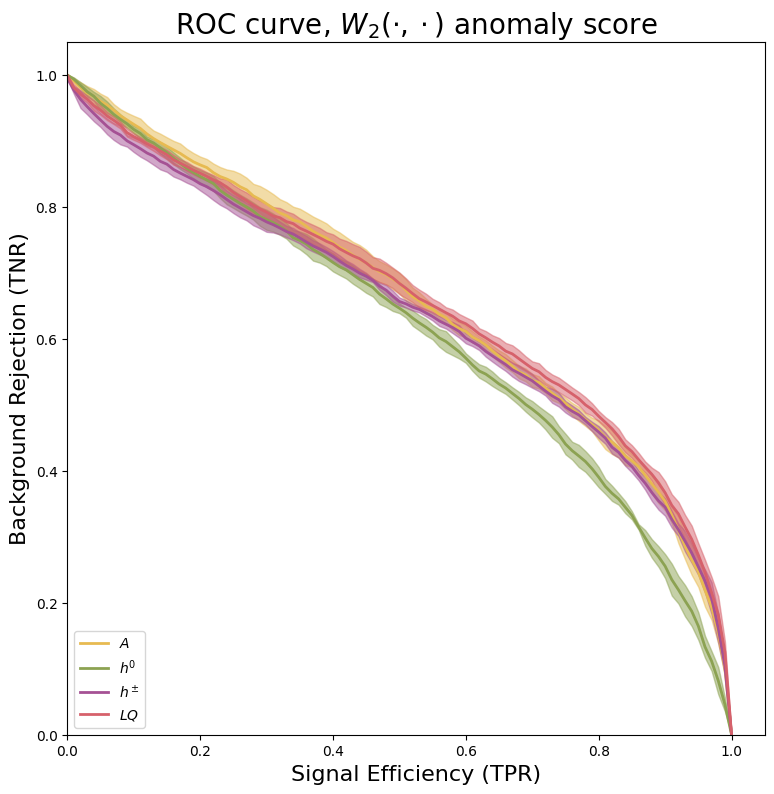

In [20]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)' # OR r'$\eps_S$'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)' # OR r'$1 - \eps_B$'
plotArgDict['title']     = r'ROC curve, $W_2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve_errorBand(av_fprList, std_fprList, plotArgDict)

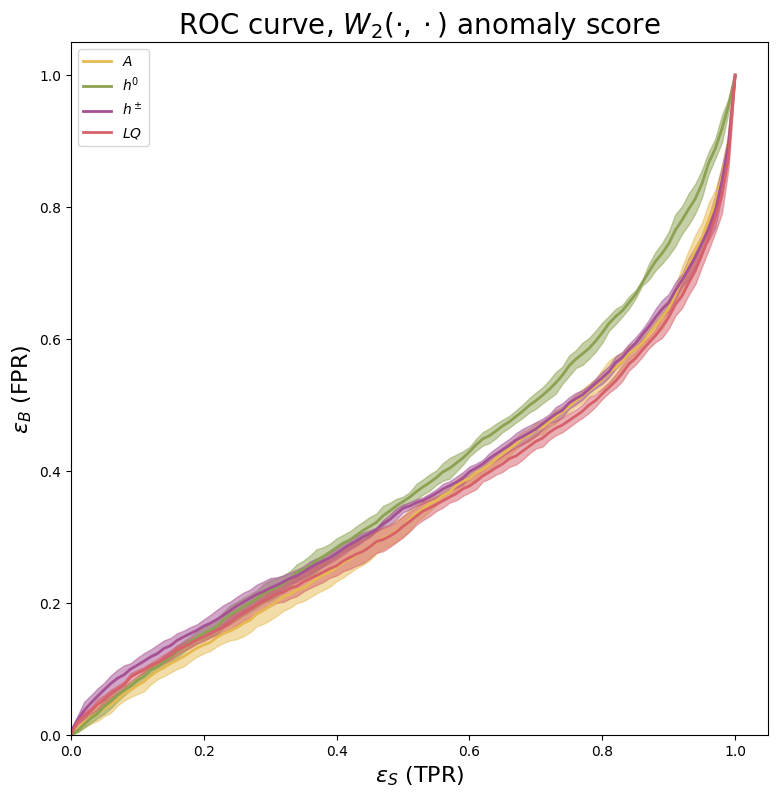

In [21]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve_errorBand(av_fprList, std_fprList, plotArgDict, TYPE='Alt')

In [22]:
av_fprInvList, std_fprInvList = [], []
for alias in sigAliasList:
  av_fprInvList.append(scoreDict['avStdQuantities'][alias]['fprInv']['mean'])
  std_fprInvList.append(scoreDict['avStdQuantities'][alias]['fprInv']['std'])

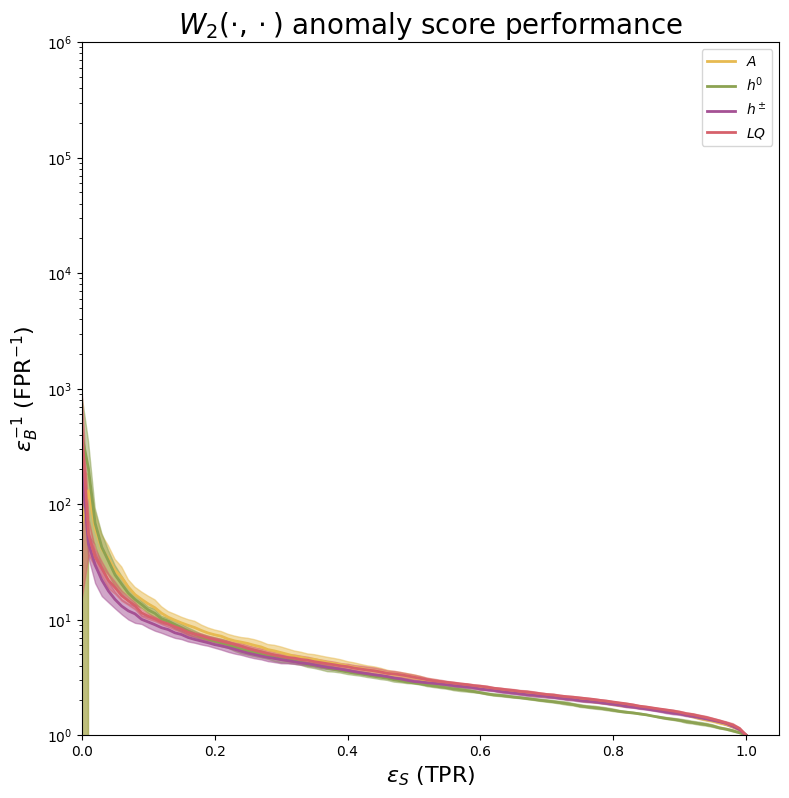

In [23]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e6)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve_errorBand(av_fprInvList, std_fprInvList, plotArgDict)

In [24]:
av_SIList, std_SIList = [], []
for alias in sigAliasList:
  av_SIList.append(scoreDict['avStdQuantities'][alias]['SI']['mean'])
  std_SIList.append(scoreDict['avStdQuantities'][alias]['SI']['std'])

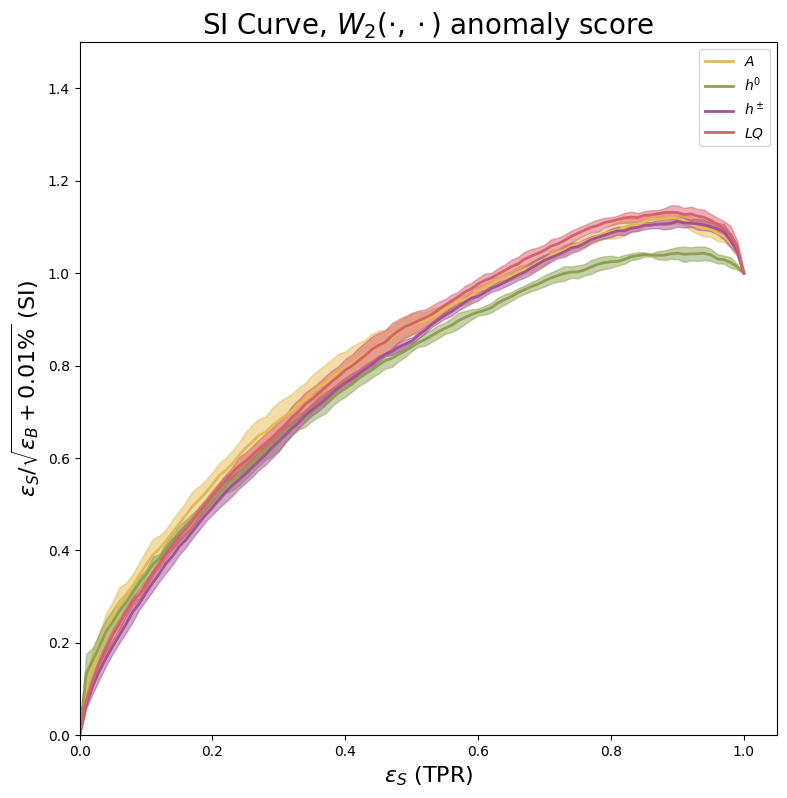

In [25]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.5)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve_errorBand(av_SIList, std_SIList, plotArgDict)

## Plot anomaly scores for all signal types

In [26]:
print(scoreDict.keys())
NAME_REPEAT = list(scoreDict.keys())[0]

dict_keys(['repeat0', 'repeat1', 'repeat2', 'repeat3', 'repeat4', 'avStdQuantities'])


In [27]:
#-- Put in convenient list format --#
scoreBkg = scoreDict[NAME_REPEAT]['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[NAME_REPEAT][name])

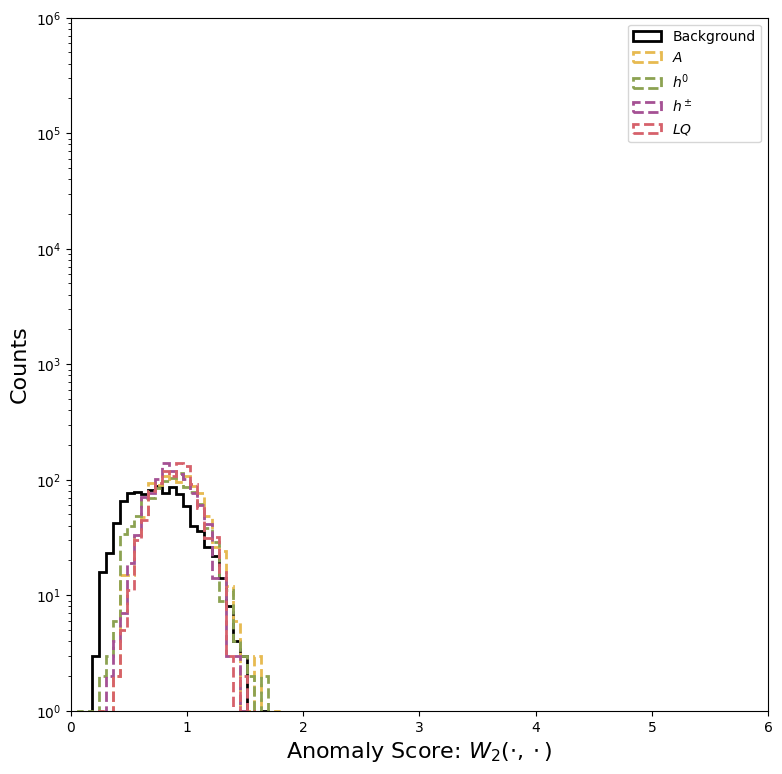

In [28]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 6)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e6)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Save final scoreDict

In [29]:
filename = basePath + dataPath + 'finalScoreDict_%s_nEvents%s_nRepeat%s_eventToEnsembleType%s.npz'%(COSTSCHEME, str(nEvents), str(NREPEAT), EVENT_TO_ENSEMBLE_TYPE)
print(filename)

if os.path.exists(filename):
  print("File already exists")
else:
  np.savez(filename, **scoreDict)

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/finalScoreDict_2D_nEvents1000_nRepeat5_eventToEnsembleTypeMIN.npz
